# Step 2: Create visual (optional)

In [1]:
#import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import contextily as ctx

In [2]:
# import census block group shape file
reg_data = "Output/ld26_reg_analysis.csv"
reg_data_import = pd.read_csv(reg_data, encoding = "ISO-8859-1", dtype={'block_group': object})
bgs = geopandas.read_file("Resources/tl_2018_04_bg.shp")
reg_data_import.head()

,county_fips,block_group,CVAP_estimate,CVAP_margin_of_error,reg_count,reg_potential,percent_reg
0,4013,040133198006,565,191,642,-77,1.136283
1,4013,040134223013,800,281,874,-74,1.092500
2,4013,040133194032,810,174,876,-66,1.081481
3,4013,040134220022,385,155,388,-3,1.007792
4,4013,040133198003,360,163,354,6,0.983333


In [3]:
bgs.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,019,004011,2,040190040112,Block Group 2,G5030,S,519901,0,+32.2022961,-110.8363653,"POLYGON ((-110.84097 32.202914, -110.840969 32..."
1,04,019,004011,4,040190040114,Block Group 4,G5030,S,656775,0,+32.1956251,-110.8364862,"POLYGON ((-110.84096 32.19832, -110.840959 32...."
2,04,019,004057,2,040190040572,Block Group 2,G5030,S,1564925,0,+32.1767494,-110.7804791,"POLYGON ((-110.789751 32.179478, -110.789741 3..."
3,04,013,216829,1,040132168291,Block Group 1,G5030,S,4948723,0,+33.7487402,-111.8552258,"POLYGON ((-111.881144 33.743625, -111.881124 3..."
4,04,019,004058,1,040190040581,Block Group 1,G5030,S,2486168,0,+32.1697878,-110.7985553,"POLYGON ((-110.806956 32.170678, -110.806956 3..."


In [4]:
#narrow to just maricopa county
maricopa_bgs = bgs.loc[bgs["COUNTYFP"] == "013", :]

In [5]:
#merged_data = pd.merge(reg_data_import, maricopa_bgs, left_on='block_group', right_on='GEOID')
merged_data = maricopa_bgs.set_index('GEOID').join(reg_data_import.set_index('block_group'))
merged_data = merged_data.dropna(how='any')
#merged_data = merged_data[["CVAP_estimate", "CVAP_margin_of_error", "reg_count", "percent_reg", "geometry"]]

In [6]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

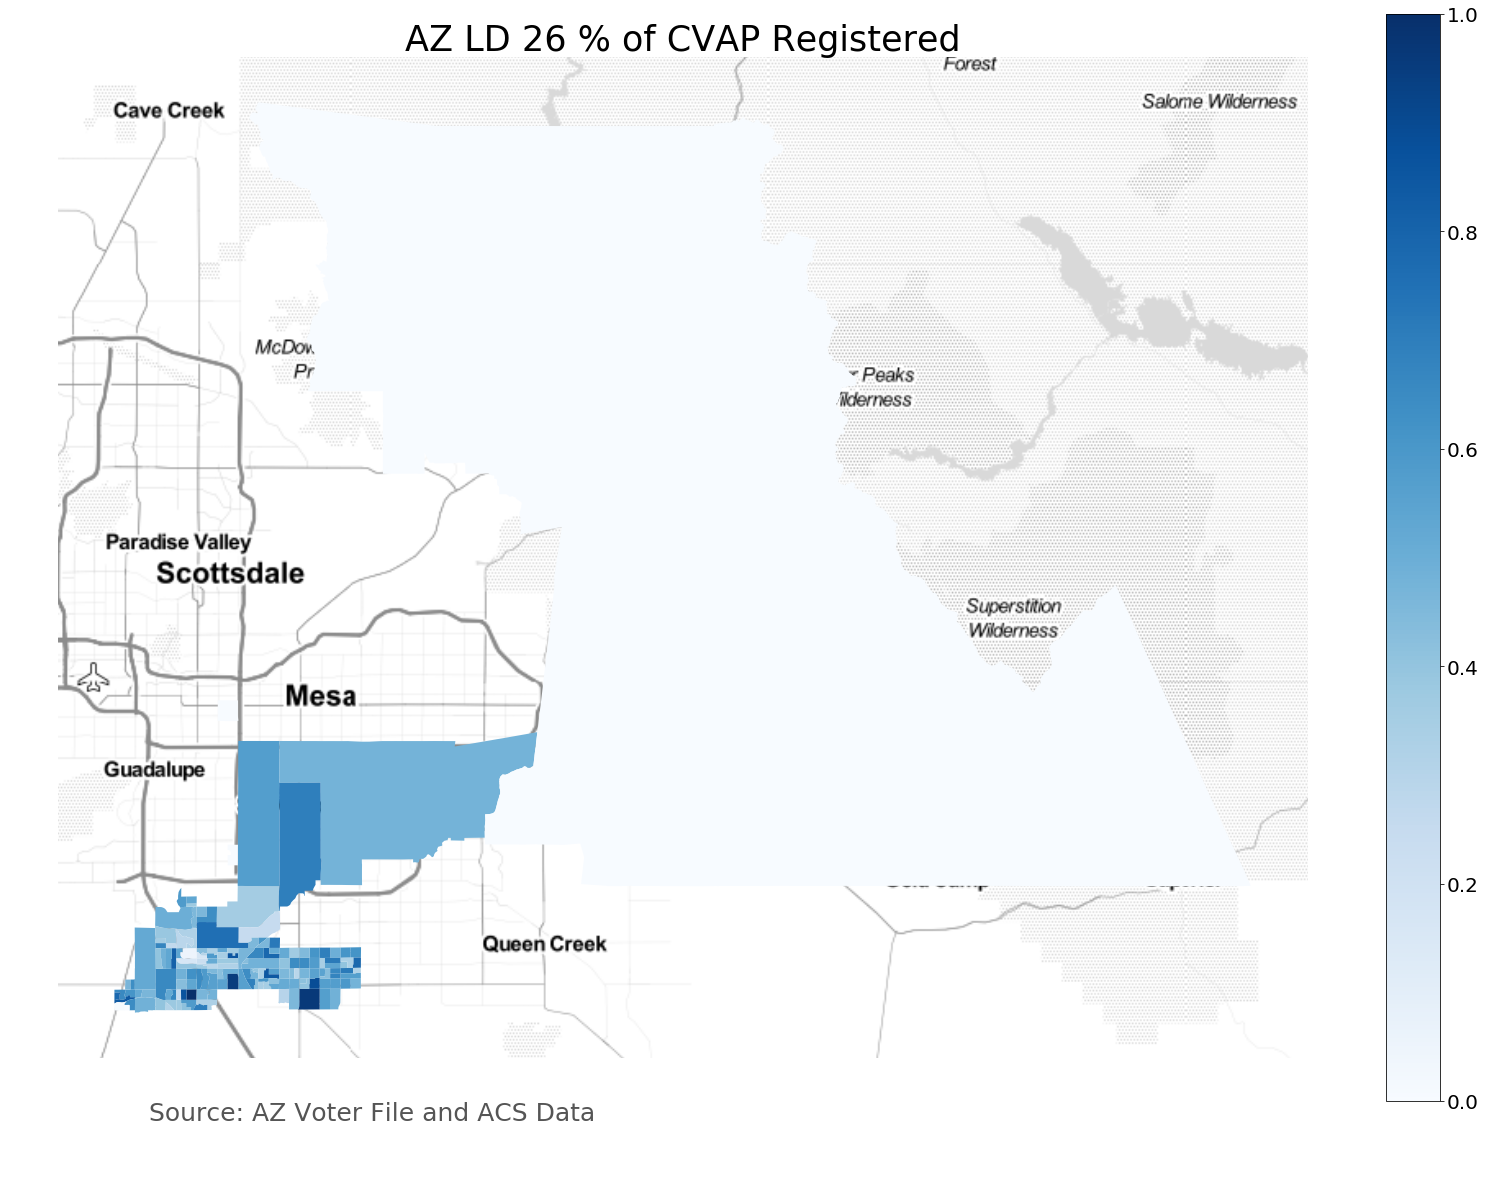

In [34]:
variable = 'percent_reg'

# set the range for the choropleth
vmin, vmax = 0, 1

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(28, 20))

# create map
merged_data = merged_data.to_crs(epsg=3395)
merged_data.plot(variable, cmap='Blues', linewidth=0.8, ax=ax)

add_basemap(ax, zoom=10, url=ctx.sources.ST_TONER_LITE)

#ax.set_ylim([3920000, 3930000])
#ax.set_xlim([-1.248, -1.242])

# add a title
ax.set_title('AZ LD 26 % of CVAP Registered', \
              fontdict={'fontsize': '35',
                        'fontweight' : '5'})

# create an annotation for the  data source
ax.annotate('Source: AZ Voter File and ACS Data',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=25, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

# remove the axis
ax.axis('off')

# this will save the figure as a high-res png. you can also save as svg
fig.savefig("Images/az_ld_26.png", dpi=1000)